# Lab 3 - DTFT, FFT, and Their Applications
The goal of this lab is to visualize frequency domain analysis. We will next apply Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT) in three real-world applications, including feature extraction, image compression, and data denoising. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 

## Task 1: Decompose Square Wave into Harmonic Components

In [2]:
def generate_square_wave(t_duration, freq, fs):
    """Generate a square wave with fundamental frequency freq of duration t_duration and sampling frequency fs

    Args:
        t_duration (float): Duration of square wave
        freq (int): Fundamental frequency of square wave
        fs (int): Sampling frequency

    Returns:
        square_wave (ndarray): Desired square wave (peak value: 1; peak-to-peak: 1)
    """
    t = np.linspace(0, t_duration, int(fs * t_duration), endpoint=False) # generate time array
    # your code below
    # We can first generate a sine function sin(2\pi*freq*t), and then apply sign function as sign(sin(2\pi*freq*t))
    sine_wave = np.sin(2*np.pi*freq*t)
    square_wave = np.sign(sine_wave)

    return t, square_wave

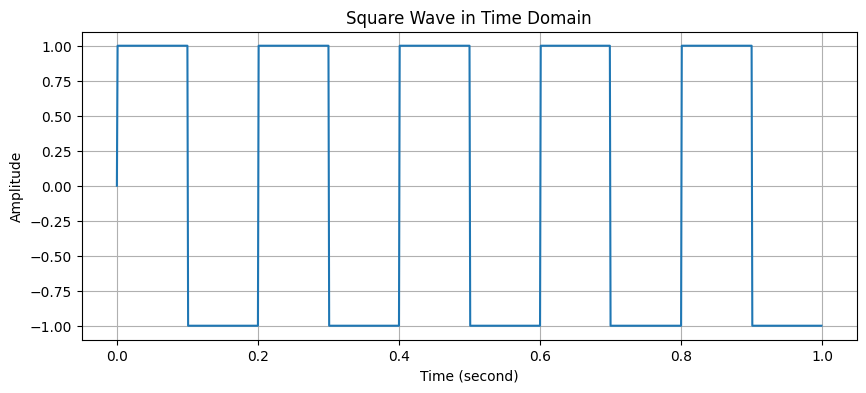

In [3]:
# Parameters for the square wave
sampling_rate = 1000  # Samples per second
duration = 1.0        # Duration of the signal in seconds
fundamental_freq = 5  # Frequency of the square wave in Hz

t, square_wave = generate_square_wave(duration, fundamental_freq, sampling_rate)

# visualize the square wave
plt.figure(figsize=(10, 4))
plt.plot(t, square_wave)
plt.title("Square Wave in Time Domain")
plt.xlabel("Time (second)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


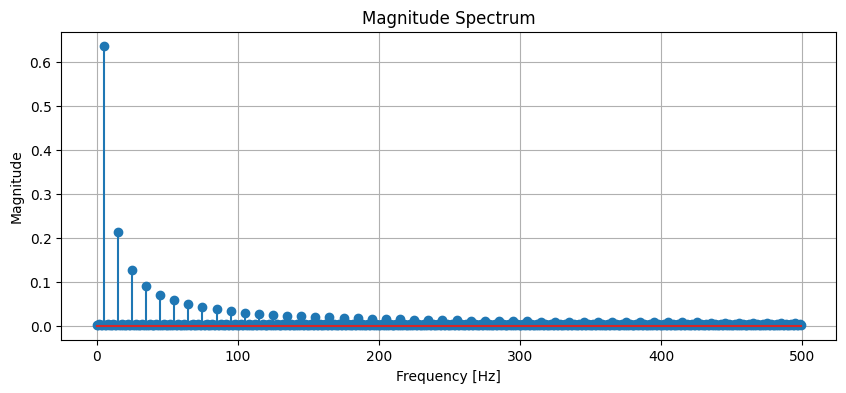

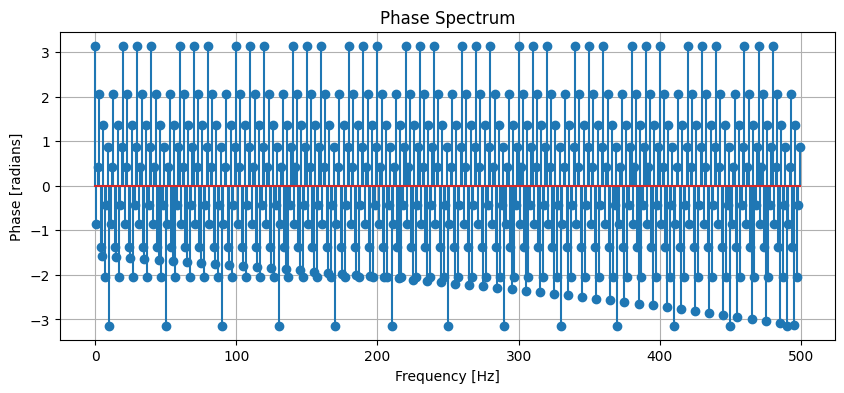

In [4]:

# Compute the DFT using numpy.fft.fft
N = len(square_wave)  # Number of samples
dft = np.fft.fft(square_wave)
frequencies = np.fft.fftfreq(N, d=1/sampling_rate)  # Frequency axis

# Compute magnitude and phase
magnitude = np.abs(dft) / N  # Normalize by N
phase = np.angle(dft)

# Plot the magnitude spectrum
plt.figure(figsize=(10, 4))
plt.stem(frequencies[:N // 2], magnitude[:N // 2])  # Single-sided spectrum
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

# Plot the phase spectrum
plt.figure(figsize=(10, 4))
plt.stem(frequencies[:N // 2], phase[:N // 2])  # Single-sided spectrum
plt.title("Phase Spectrum")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [radians]")
plt.grid()
plt.show()

In [5]:

def reconstruct_wave(harmonics, t, frequencies):
    """_summary_

    Args:
        harmonics (ndarray): Set of frequencies of harmonic components to use
        t (ndarray): Time vector
        frequencies (ndarray): Frequency components

    Returns:
        reconstruction: Reconstructed signal using harmonic components
    """
    # initialize the recosntructed signal
    reconstruction = np.zeros_like(t, dtype=complex)
    
    for harmonic in harmonics:
        idx = np.argmin(np.abs(frequencies - harmonic))  # Find the index of the harmonic
        # your code goes below
        reconstruction += dft[idx] * np.exp(2j * np.pi * frequencies[idx] * t)
    
    reconstruction = reconstruction / len(dft)
    # return reconstruction
    return np.real(reconstruction)

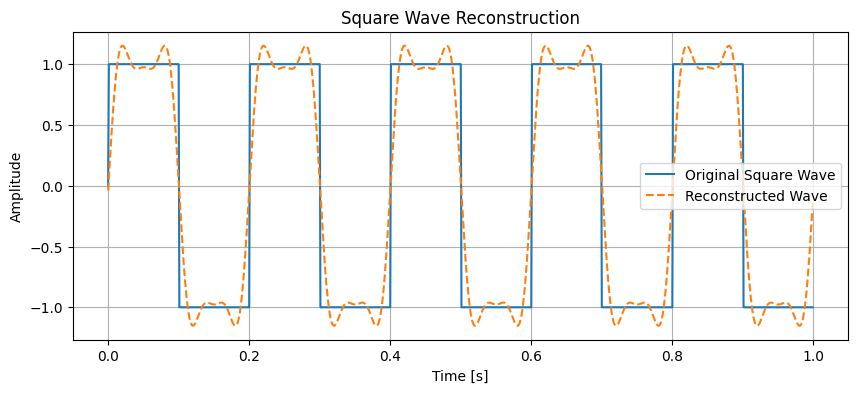

In [6]:

# call the reconstruct_wave to reconstruct the square wave
harmonics_to_use = np.array(list(range(-5, 5))) * fundamental_freq  
reconstructed_wave = reconstruct_wave(harmonics_to_use, t, frequencies)

# Plot the original and reconstructed square wave
plt.figure(figsize=(10, 4))
plt.plot(t, square_wave, label="Original Square Wave")
plt.plot(t, reconstructed_wave, label="Reconstructed Wave", linestyle="--")
plt.title("Square Wave Reconstruction")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

## Task 2: Image Compression using FFT 

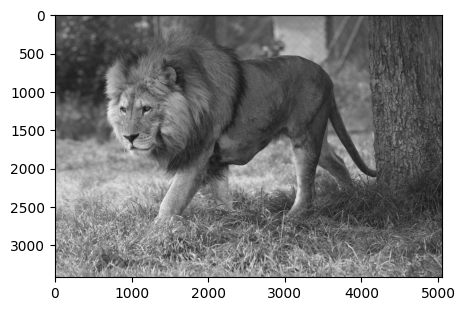

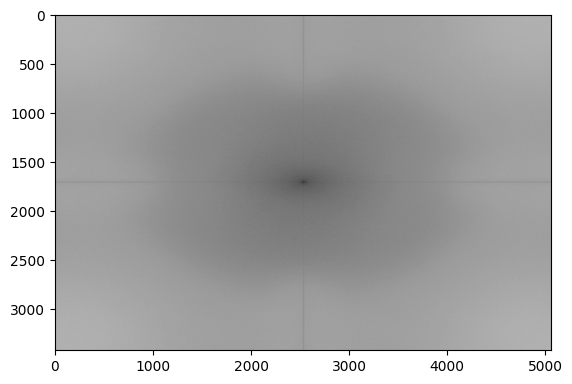

In [7]:
# Load and display image
img = Image.open("lion.jpg").convert('L')
img = np.array(img)
_ = plt.figure(figsize=(5, 5))
_ = plt.imshow(img, cmap ='gray', vmin=0, vmax=255)

img_fft = np.fft.fft2(img)  # Perform FFT on the image
img_fft_log = np.log(np.abs(np.fft.fftshift(img_fft)) + 1)  # Convert FFt to log scale
# Visualize FFT
plt.figure()
_ = plt.imshow(256 - img_fft_log, cmap='gray')

In [8]:
def compress_img(img_fft, ratio):
    """Compress an image by keeping a specified percentage of FFT components

    Args:
        img_fft (ndarray): FFT of image
        ratio (float): The ratio of FFT components to keep
    """
    # your code goes below
    img_fft_flat = img_fft.flatten()
    img_fft_sort = np.sort(np.abs(img_fft_flat))[::-1]  # Sort img_fft by magnitude
    thresh = img_fft_sort[int(len(img_fft_sort) * ratio)]  # Compute threshold of magnitude
    ind = np.abs(img_fft) > thresh  # Find indices of components that are larger than threshold
    fft_keep = img_fft * ind  # Zero out components with small magnitudes
    compressed_img = np.abs(np.fft.ifft2(fft_keep))  # Use inverse FFt
    _ = plt.imshow(compressed_img, cmap='gray')  # Show reconstructed image without inverting colors
    plt.title(f"Compressed Image with {ratio * 100:.1f}% Components Kept", fontsize=12)

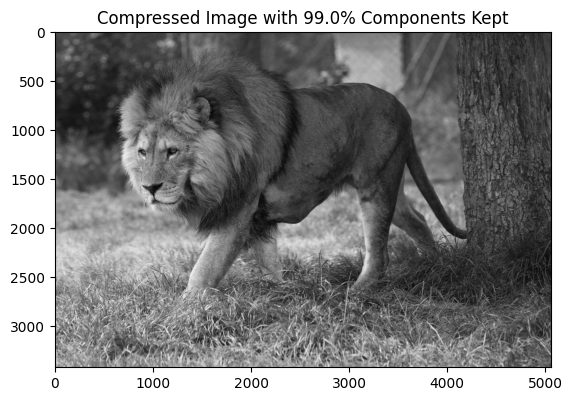

In [9]:
# call compress_img with ratio = 0.99, 0.05, 0.01, 0.002
compress_img(img_fft, 0.99)


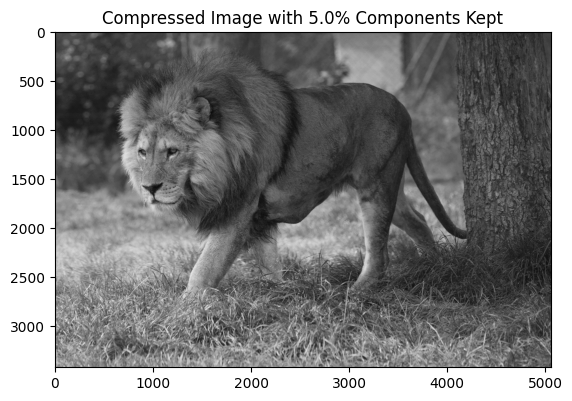

In [10]:
compress_img(img_fft, 0.05)


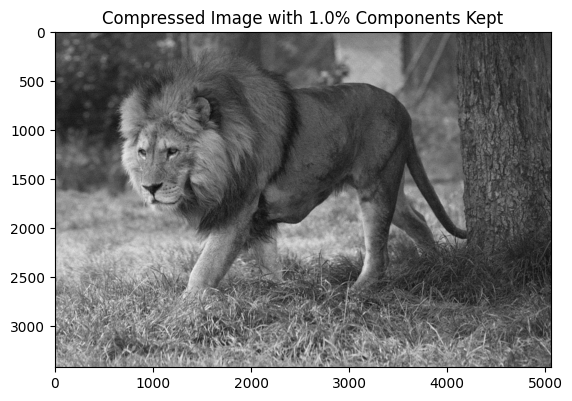

In [11]:
compress_img(img_fft, 0.01)


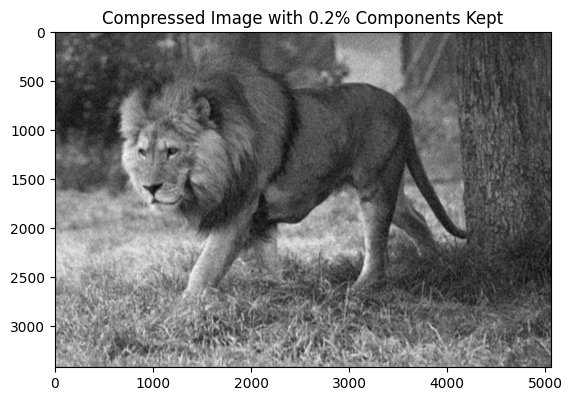

In [12]:
compress_img(img_fft, 0.002)


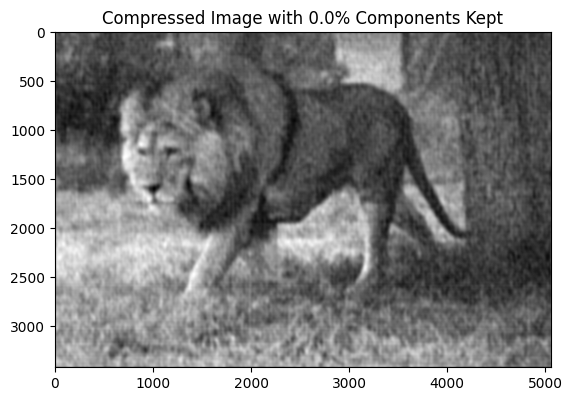

In [13]:
compress_img(img_fft, 0.0003)


### Discussion: FFT for Data Storage and Communication Optimization

Visual Quality vs. Compression Rate:

- 99% coefficients: Perfect quality, 1% storage reduction

- 5% coefficients: Excellent quality, 95% storage reduction

- 1% coefficients: Good quality, 99% storage reduction

- 0.2% coefficients: Acceptable quality, 99.8% storage reduction

Compression Efficiency:

- Original image size: ~4MB

- Retaining only 1% of FFT coefficients:
  - Reduces storage by 99%
  - Maintains remarkable image quality
  - Compression ratio = 100:1


## Task 3: Denoising a Signal using FFT

In [14]:
def generate_sine(duration, frequency, sample_rate):
    """Generates samples of a sine wave.

    Samples are generated according to following equation:

        y(t) = A sin(2*pi*f*t)

    Args:
        frequency: The frequency of the note.
        duration: The length of the note in seconds.
        amplitude: The amplitude of the note.
        sample_rate: The sample rate.

    Returns:
        An array of samples.
    """
    # Calculate total number of samples based on duration and sample rate
    num_samples = int(duration * sample_rate)
    
    # Generate time points
    t = np.linspace(0, duration, num_samples)
    
    # Generate sine wave using the formula y(t) = sin(2πft)
    sine_wave = np.sin(2 * np.pi * frequency * t)
    
    return sine_wave

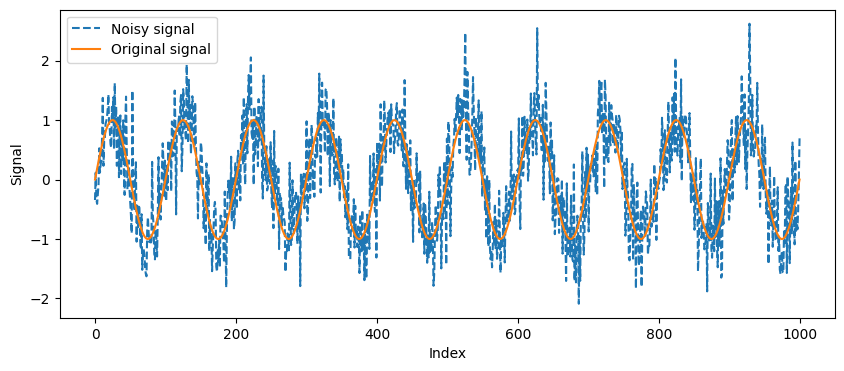

In [15]:
# call generate_sine to generate function g and the noisy signal
# your code here
g = generate_sine(duration=1.0, frequency=10, sample_rate=1000)
noise = np.random.normal(0, 0.5, len(g))
noisy_signal = g + noise

plt.figure(figsize=(10, 4))
_ = plt.plot(range(len(noisy_signal)), noisy_signal, label="Noisy signal", linestyle="--")
_ = plt.plot(range(len(g)), g, label="Original signal")
plt.xlabel("Index")
plt.ylabel("Signal")
plt.legend()
plt.show()

In [17]:
def filter_with_psd(signal, sampling_rate, threshold_ratio):
    """
    Filters a signal based on its Power Spectral Density (PSD)

    Args:
        signal (ndarray): The input time-domain signal.
        sampling_rate (float): The sampling rate of the signal (Hz).
        threshold_ratio (float): Fraction of the PSD to retain (e.g., 0.1 for top 10%).

    Returns:
        filtered_signal (ndarray): The filtered signal in the time domain.
    """
    # your code goes below
    # Compute the FFT of the signal
    fft_signal = np.fft.fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/sampling_rate)
    
    # Compute the Power Spectral Density (PSD)
    psd = np.abs(fft_signal) ** 2
    
    # Sort the PSD to find the threshold
    sorted_psd = np.sort(psd)
    threshold = sorted_psd[int((1-threshold_ratio)*len(sorted_psd))]
    
    # Create a mask to retain frequencies with PSD above the threshold
    mask = psd > threshold
    
    # Apply the mask to the FFT signal
    filtered_fft = fft_signal * mask
    
    # Reconstruct the signal using the inverse FFT
    filtered_signal = np.real(np.fft.ifft(filtered_fft))

    # Compute the mean squared error between the original and filtered signals
    error = np.mean((noisy_signal - filtered_signal) ** 2)
    print(error)

    # Plot original and filtered signals for comparison
    plt.figure(figsize=(10, 4))
    plt.plot(noisy_signal, label='Original Signal')
    plt.plot(filtered_signal, label='Filtered Signal', color='orange')
    plt.title('Signal Comparison')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

    return filtered_signal


0.26275438974987675


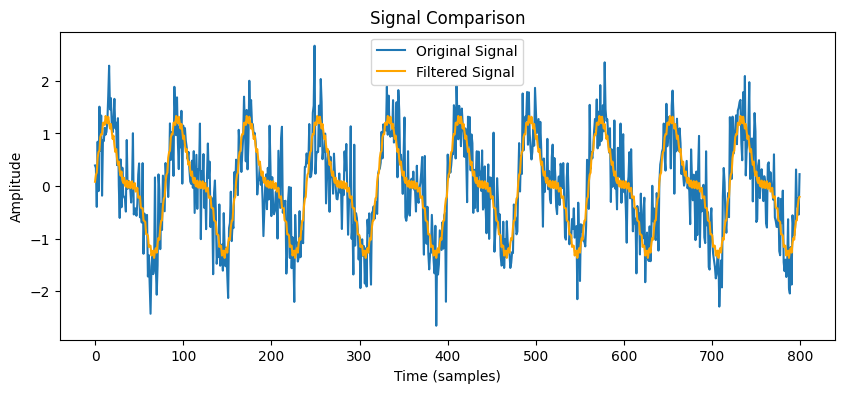

0.21682090118370323


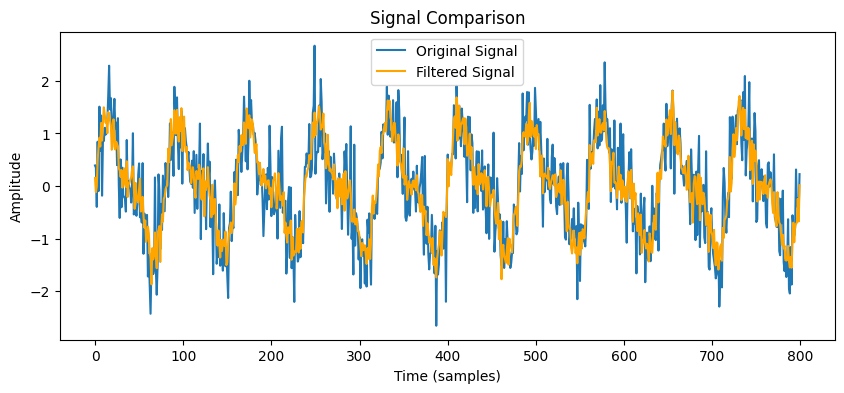

0.18346559339528085


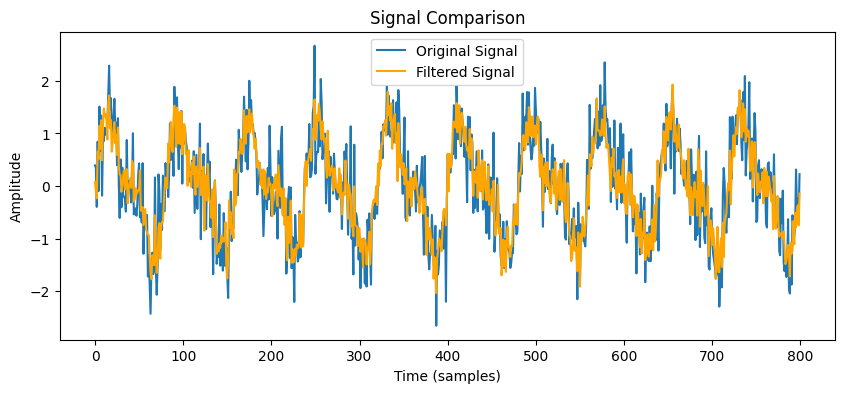

0.13113467016945413


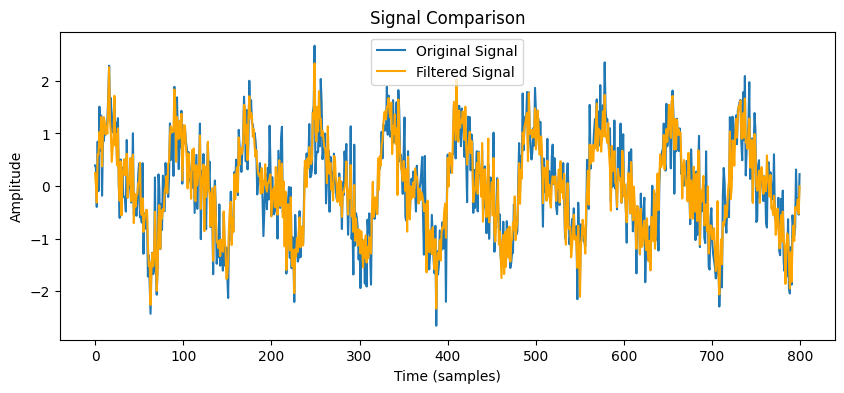

0.09171194163083328


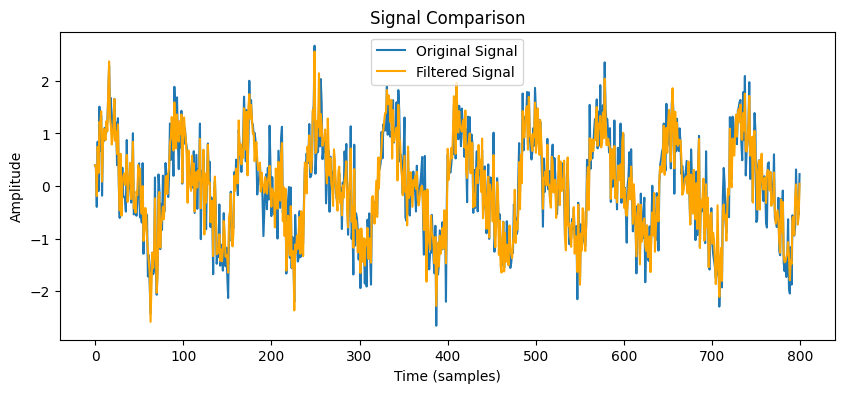

In [18]:
# Compare filtering effect with different threshold ratios
# Generate test signal f(t)
sampling_rate = 800
t = np.linspace(0, 1, sampling_rate)
f_t = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*20*t)  # Original f(t)
noise = np.random.normal(0, 0.5, len(t))
noisy_signal = f_t + noise

# Test different threshold ratios
threshold_ratios = [0.01, 0.05, 0.1, 0.2, 0.3]
for i, ratio in enumerate(threshold_ratios):
    filtered = filter_with_psd(noisy_signal, sampling_rate, ratio)

### Observations with Different Threshold Ratios

Effect of Different Thresholds
- **0.3 - 0.2**: Signal remains noisy, retaining too much noise components
- **0.1**: Partial noise reduction, but still shows random fluctuations
- **0.05 - 0.01**: Clear signal recovery
  - At 0.01, reconstructed signal closely resembles the original pre-noise signal
  - Shows two clear sinusoidal components

This demonstrates that most signal power is concentrated in very few frequency components (≈1%), while noise is distributed across all frequencies.